# Описание:

Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Описание колонок:


value – значения метрики


experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

## Подготовка и исследование данных

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np, scipy.stats as st
import statsmodels.api as sm

%matplotlib inline

from tqdm.auto import tqdm

plt.style.use('ggplot')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [6]:
df = pd.read_csv('hw_bootstrap.csv', sep = ';', decimal=',')
df_test = df.query('experimentVariant == "Treatment"')
df_control = df.query('experimentVariant == "Control"')

In [6]:
df_test.value.mean()

10.367236377039061

In [7]:
df_control.value.mean()

10.026866533804295

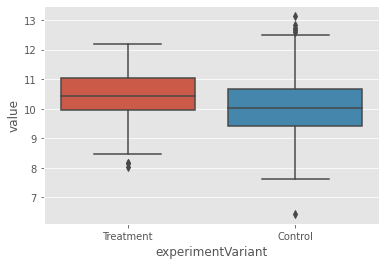

In [8]:
sns.boxplot (x = 'experimentVariant', y = 'value', data = df)

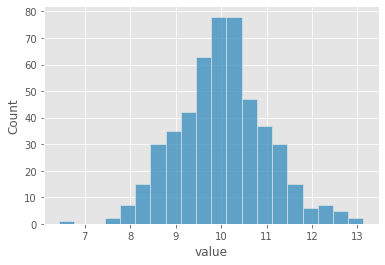

In [13]:
sns.histplot(data=df_control, x='value', bins=20)

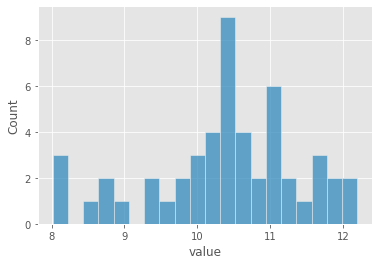

In [14]:
sns.histplot(data=df_test, x='value', bins=20)

In [15]:
pg.normality(df_test.value, method='normaltest') 

,W,pval,normal
value,2.667697,0.263461,True


In [16]:
pg.normality(df_control.value, method='normaltest')

,W,pval,normal
value,2.943459,0.229528,True


Распределения в двух выборках проходят тест на нормальность. Хотя визуально, распределение в тестовой группе кажется не очень нормальным. Плюс, там довольно мало наблюдений. Уже на этом шаге кажется, что методологически бутстрап будет более корректен. 

## Бутстрап

In [33]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [34]:
np.random.seed(5)

In [35]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

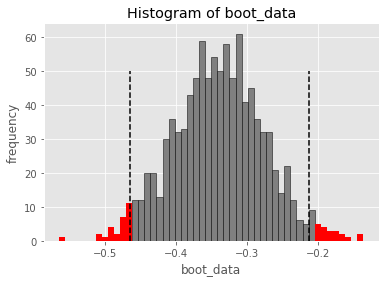

In [36]:
booted_data = get_bootstrap(df_control.value, df_test.value)

In [37]:
booted_data["p_value"] #альфа

7.792175748532068e-08

In [41]:
7.792175748532068e-08 < 0.05

True

In [42]:
booted_data["quants"] # ДИ

,0
0.025,-0.465126
0.975,-0.212540


## t-тест

In [45]:
stats.ttest_ind(df_control.value, df_test.value)

Ttest_indResult(statistic=-2.3318589655730135, pvalue=0.02006953912735476)

## U-теста Mann-Whitney

In [46]:
ss.mannwhitneyu(df_control.value, df_test.value, alternative='two-sided')

MannwhitneyuResult(statistic=9508.0, pvalue=0.005236419587596797)

Бутстрап показал присутствие статически значимых различий между средней контрольной и экспериментальной группы (в ДИ не входит 0, и p-value меньше 0.05). T-тест и U-теcт также показал значимые различия между средними наших выборок. Тем не менее бутстрап больше подходит так как, у нас в тестовой группе есть вопросы к нормальности распределения и размеру выборки. Но тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение, поэтому лучше дополнительно проверить ещё раз бутстрапом, но с медианой. 

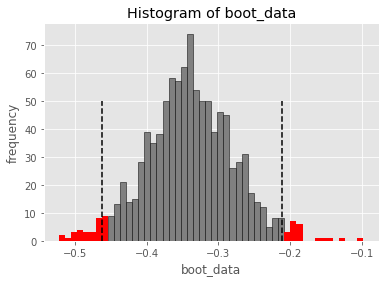

{'boot_data': [-0.2736577009222465,
  -0.3073671174345787,
  -0.2621571692765894,
  -0.32543290355351573,
  -0.26578843004187824,
  -0.24167849610831915,
  -0.4020958643752799,
  -0.2807819891093999,
  -0.30756092108066113,
  -0.3694758872340671,
  -0.3455017634272419,
  -0.3260598091110385,
  -0.4670285234074978,
  -0.3367495190798184,
  -0.3441177873564616,
  -0.32628367740622366,
  -0.19680662140732963,
  -0.3223971198719351,
  -0.3735752138011943,
  -0.3085481642051473,
  -0.2578821835804206,
  -0.37130498233132414,
  -0.3223074878687324,
  -0.30228507061366905,
  -0.36699909759188465,
  -0.2745347740298154,
  -0.3039597160639751,
  -0.33617494172301043,
  -0.3379177426614248,
  -0.34072225730647787,
  -0.284443290578718,
  -0.3744601208820111,
  -0.3571468455275788,
  -0.41320338916296784,
  -0.3444711854897786,
  -0.39409306069723193,
  -0.405155493678965,
  -0.29701873497822007,
  -0.3515535500851801,
  -0.24265202351157278,
  -0.31231220978146723,
  -0.2984577527339365,
  -0.15

In [7]:
get_bootstrap(
    df_control.value, # числовые значения первой выборки
    df_test.value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

И тут бутстрап показал значимые различия. Принимаем альтернативную гипотезу. 